In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.patches as patches
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import astropy.time
from ndcube import NDCube
from ndcube.extra_coords import (SkyCoordTableCoordinate, TimeTableCoordinate,
                                 QuantityTableCoordinate)
from scipy.interpolate import interp1d
from skimage import draw

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   
from glob import glob
import h5py

In [2]:
eui_files = sorted(glob("../../src/EUI/HRI/euv174/20221024/solo_L2_eui-hri*.fits"))
eui_map_seq = sunpy.map.Map(eui_files[:],sequence=True,memmap=True)

In [3]:
Txshift_hri, Tyshift_hri = (1.66986 + 2.49223)*u.arcsec,(7.60204 - 2.76366 )*u.arcsec

In [4]:
with h5py.File("../../src/EUI/HRI/euv174/20221024/coalign_shifts_step.h5","r") as f:
    eui_map_seq_coalign_shifts_x = f["x"][()]
    eui_map_seq_coalign_shifts_y = f["y"][()]
eui_map_seq_coalign_shifts = {"x":eui_map_seq_coalign_shifts_x*u.arcsec,"y":eui_map_seq_coalign_shifts_y*u.arcsec}

In [5]:
eui_map_seq_coalign = coalignment.mapsequence_coalign_by_match_template(eui_map_seq,shift=eui_map_seq_coalign_shifts)

In [6]:
eis_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")

In [7]:
eis_hhflare_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_derot_repro_hrifov.fits")

In [8]:
eui_map_0_shift = eui_map_seq_coalign[0]

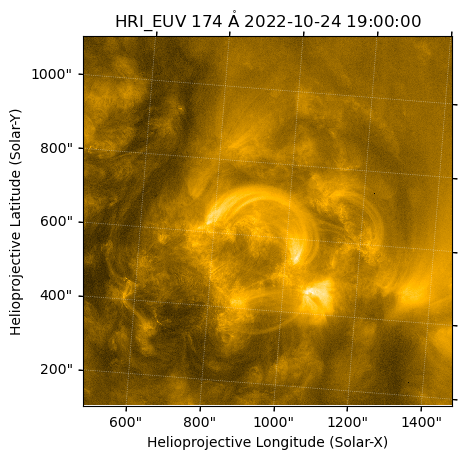

In [9]:
eui_map_0_shift.plot()

In [10]:
eui_map_181_shift = eui_map_seq_coalign[181].shift_reference_coord(Txshift_hri, Tyshift_hri)
eui_map_181_shift.meta["rsun_ref"] = eis_195_velmap_derot_repro_hrifov.meta["rsun_ref"]
eui_map_wcs_all = eui_map_181_shift.wcs

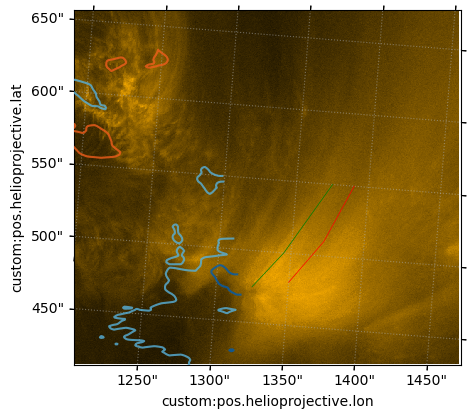

In [11]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111,projection=eui_map_wcs_all)
# eui_map_0_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))
# eui_map_0_shift.plot(axes=ax)

ax.imshow(eui_map_0_shift.data,origin="lower",cmap="solar orbiterhri_euv174",norm=ImageNormalize(stretch=AsinhStretch(0.1)),
          interpolation="none")

bounds = ax.axis()
eis_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                   axes=ax)
ax.set_xlim(1500,2046)
ax.set_ylim(500,1000)

slit_1_coords = SkyCoord([1325,1345,1375]*u.arcsec,
                         [475,500,550]*u.arcsec,
                         frame=eui_map_181_shift.coordinate_frame)

slit_2_coords = SkyCoord([1350,1372,1390]*u.arcsec,
                            [480,510,550]*u.arcsec,
                            frame=eui_map_181_shift.coordinate_frame)

# slit_2_coords = SkyCoord([1360,1385,1405]*u.arcsec,
#                             [470,510,550]*u.arcsec,
#                             frame=eui_map_seq[181].coordinate_frame)

ax.plot_coord(slit_1_coords, color="green", lw=0.5, ls="-")
ax.plot_coord(slit_2_coords, color="red", lw=0.5, ls="-")
ax.grid("on",ls=":",alpha=0.5)

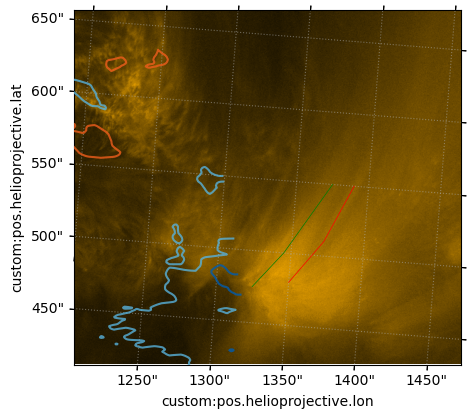

In [12]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111,projection=eui_map_wcs_all)
# eui_map_0_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))
# eui_map_0_shift.plot(axes=ax)

ax.imshow(eui_map_seq[230].data,origin="lower",cmap="solar orbiterhri_euv174",norm=ImageNormalize(stretch=AsinhStretch(0.1)))

bounds = ax.axis()
eis_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                   axes=ax)
ax.set_xlim(1500,2046)
ax.set_ylim(500,1000)

# slit_1_coords = SkyCoord([1325,1345,1375]*u.arcsec,
#                          [475,500,550]*u.arcsec,
#                          frame=eui_map_seq[181].coordinate_frame)

# slit_2_coords = SkyCoord([1360,1385,1405]*u.arcsec,
#                             [470,510,550]*u.arcsec,
#                             frame=eui_map_seq[181].coordinate_frame)

ax.plot_coord(slit_1_coords, color="green", lw=0.5, ls="-")
ax.plot_coord(slit_2_coords, color="red", lw=0.5, ls="-")
ax.grid("on",ls=":",alpha=0.5)

In [13]:
def get_intensity_spacetime_cut(slit_coords,map_seq):
    pixels_0 = sunpy.map.pixelate_coord_path(eui_map_181_shift,slit_coords)
    pixels_0_distance = np.zeros_like(pixels_0,dtype=np.float64)*u.arcsec

    slit_anchor_index = []
    for slit_anchor_ in slit_coords:
        slit_anchor_index.append(np.argmin(pixels_0.separation(slit_anchor_)))
    slit_anchor_distance = np.zeros_like(slit_anchor_index,dtype=np.float64)
    for ii, slit_anchor_index_ in enumerate(slit_anchor_index):
        if ii == 0:
            pass
        else:
            slit_anchor_distance[ii] = pixels_0[slit_anchor_index[ii]].separation(pixels_0[slit_anchor_index[ii-1]]).to_value(u.arcsec) + slit_anchor_distance[ii-1]
    
    slit_anchor_distance = slit_anchor_distance*u.arcsec

    for ii, slit_anchor_index_ in enumerate(slit_anchor_index[:-1]):
        for jj in range(slit_anchor_index[ii],slit_anchor_index[ii+1]):
            pixels_0_distance[jj] = slit_anchor_distance[ii] + pixels_0[jj].separation(pixels_0[slit_anchor_index_]).to(u.arcsec)
    pixels_0_distance[-1] = slit_anchor_distance[-1] 
    pixels_0_distance = pixels_0_distance.to_value(u.rad)*map_seq[181].dsun
    

    intensity = []
    for map_ in map_seq:
        # pixels_ = sunpy.map.pixelate_coord_path(map_,slit_coords)
        map_fake_ = sunpy.map.Map(map_.data, eui_map_181_shift.meta)
        pixels_ = pixels_0
        pixels_distance_ = pixels_.separation(pixels_[0])
        intensity_ = sunpy.map.sample_at_coords(map_fake_,pixels_)
        intensity.append(intensity_)
        # intensity_interp_func_ = interp1d(pixels_distance_.to_value("arcsec"),intensity_.value,kind="linear",fill_value="extrapolate")
        # intensity.append(intensity_interp_func_(pixels_0_distance.to_value("arcsec"))*intensity_.unit)
    
    return pixels_0, pixels_0_distance, u.Quantity(intensity)

In [14]:
slit_1_pixels_0, slit_1_pixels_0_distance ,slit_1_intensity = get_intensity_spacetime_cut(slit_1_coords,eui_map_seq_coalign)

In [15]:
def pixelate_coord_thick_path(smap, coord_path,thick=1):
    px, py = smap.wcs.world_to_pixel(coord_path)
    # px, py =  np.rint(px).astype(int),  np.rint(py).astype(int)

    pix_x, pix_y = [], []
    for i in range(len(px) - 1):
        this_pix_x, this_pix_y = _intersected_pixels_thick(x1=px[i], y1=py[i], x2=px[i+1], y2=py[i+1],thick=thick)

        # After the first line segment, skip the start point since it is the same as the end point
        # of the previous line segment
        if i > 0:
            this_pix_x = this_pix_x[1:,:]
            this_pix_y = this_pix_y[1:,:]
        pix_x.append(this_pix_x)
        pix_y.append(this_pix_y)
    # pix_x = np.vstack(pix_x)
    # pix_y = np.vstack(pix_y)

    pixel_coords = [smap.wcs.pixel_to_world(pix_x_, pix_y_) for pix_x_, pix_y_ in zip(pix_x, pix_y)]
    return pixel_coords

def _intersected_pixels_thick(*, x1, y1, x2, y2,thick):
    """
    Returns an array of all pixel coordinates which the line defined by `x1, y1` and
    `x2, y2` crosses.

    Parameters
    ----------
    x1, y1, x2, y2 : `float`
    """
    
    # yy, xx = draw.line(y1, x1, y2, x2)

    xx, yy = sunpy.map.maputils._intersected_pixels(x1=x1, y1=y1, x2=x2, y2=y2).T

    rotation_angle = np.arctan2(y2 - y1, x2 - x1)

    thick = thick/np.cos(rotation_angle/2)

    polygon_x = np.array([0.5, -0.5, -0.5, 0.5])
    polygon_y = np.array([thick, thick, -thick, -thick])

    polygon_x_rot = polygon_x * np.cos(rotation_angle) - polygon_y * np.sin(rotation_angle) 
    polygon_y_rot = polygon_x * np.sin(rotation_angle) + polygon_y * np.cos(rotation_angle) 

    yy_thick_0, xx_thick_0 = draw.polygon(polygon_y_rot + yy[0], polygon_x_rot + xx[0])
    # yy_thick_0, xx_thick_0 = draw.ellipse(yy[0], xx[0], thick, 0.5, rotation=rotation_angle)

    yy_thick = np.zeros((len(yy),len(yy_thick_0)))
    xx_thick = np.zeros((len(xx),len(xx_thick_0)))

    yy_thick[0,:] = yy_thick_0
    xx_thick[0,:] = xx_thick_0

    for ii in range(1, len(yy)):
        yy_thick[ii,:], xx_thick[ii,:] = draw.polygon(polygon_y_rot + yy[ii], polygon_x_rot + xx[ii])
    
    return  xx_thick, yy_thick

In [16]:
def get_intensity_spacetime_cut_new(slit_coords,map_seq,thick=1.5):
    pixels_0 = pixelate_coord_thick_path(eui_map_181_shift,slit_coords,thick=thick)
    pixels_center = sunpy.map.pixelate_coord_path(eui_map_181_shift,slit_coords)

    pixels_center_distance = np.zeros_like(pixels_center,dtype=np.float64)*u.arcsec

    slit_anchor_index = []
    for slit_anchor_ in slit_coords:
        slit_anchor_index.append(np.argmin(pixels_center.separation(slit_anchor_)))
    slit_anchor_distance = np.zeros_like(slit_anchor_index,dtype=np.float64)
    for ii, slit_anchor_index_ in enumerate(slit_anchor_index):
        if ii == 0:
            pass
        else:
            slit_anchor_distance[ii] = pixels_center[slit_anchor_index[ii]].separation(pixels_center[slit_anchor_index[ii-1]]).to_value(u.arcsec) + slit_anchor_distance[ii-1]
    
    slit_anchor_distance = slit_anchor_distance*u.arcsec

    for ii, slit_anchor_index_ in enumerate(slit_anchor_index[:-1]):
        for jj in range(slit_anchor_index[ii],slit_anchor_index[ii+1]):
            pixels_center_distance[jj] = slit_anchor_distance[ii] + pixels_center[jj].separation(pixels_center[slit_anchor_index_]).to(u.arcsec)
    pixels_center_distance[-1] = slit_anchor_distance[-1] 
    pixels_center_distance = pixels_center_distance.to_value(u.rad)*map_seq[181].dsun


    intensity = []
    for map_ in map_seq[:]:
        map_fake_ = sunpy.map.Map(map_.data, eui_map_181_shift.meta)
        intensity_ = np.zeros_like(pixels_center)
        for ii, slit_anchor_index_ in enumerate(slit_anchor_index[:-1]):
            pixels_ = pixels_0[ii]
            if ii == 0:
                intensity_[slit_anchor_index[ii]:slit_anchor_index[ii+1]+1] = \
                    np.nanmean(sunpy.map.sample_at_coords(map_fake_,pixels_.flatten()).reshape(pixels_.shape[0],pixels_.shape[1]),axis=1)
            else:
                intensity_[slit_anchor_index[ii]+1:slit_anchor_index[ii+1]+1] = \
                    np.nanmean(sunpy.map.sample_at_coords(map_fake_,pixels_.flatten()).reshape(pixels_.shape[0],pixels_.shape[1]),axis=1)
        intensity.append(intensity_)
    
    return pixels_center, pixels_center_distance, pixels_0, u.Quantity(intensity)

In [17]:
slit_1_pixels_0_new, slit_1_pixels_0_distance_new,slit_1_pixels_0_new_all,slit_1_intensity_new = get_intensity_spacetime_cut_new(slit_1_coords,eui_map_seq_coalign,thick=3)

In [18]:
slit_1_spacetime_wcs = (SkyCoordTableCoordinate(slit_1_pixels_0,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

In [19]:
slit_1_spacetime_cube = NDCube(slit_1_intensity,slit_1_spacetime_wcs)

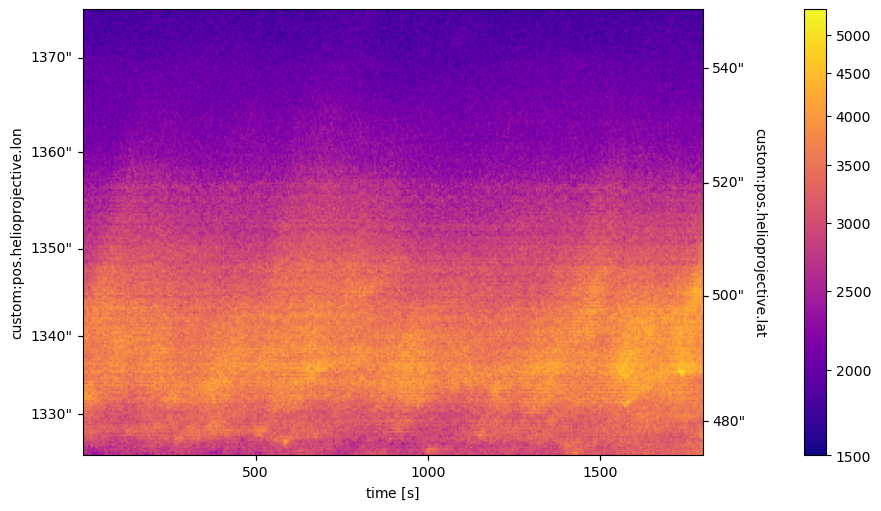

In [20]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
slit_1_spacetime_cube.plot(plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)))
plt.colorbar()

In [21]:
slit_1_spacetime_wcs_new = (SkyCoordTableCoordinate(slit_1_pixels_0_new,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs
slit_1_spacetime_cube_new = NDCube(slit_1_intensity_new,slit_1_spacetime_wcs_new)

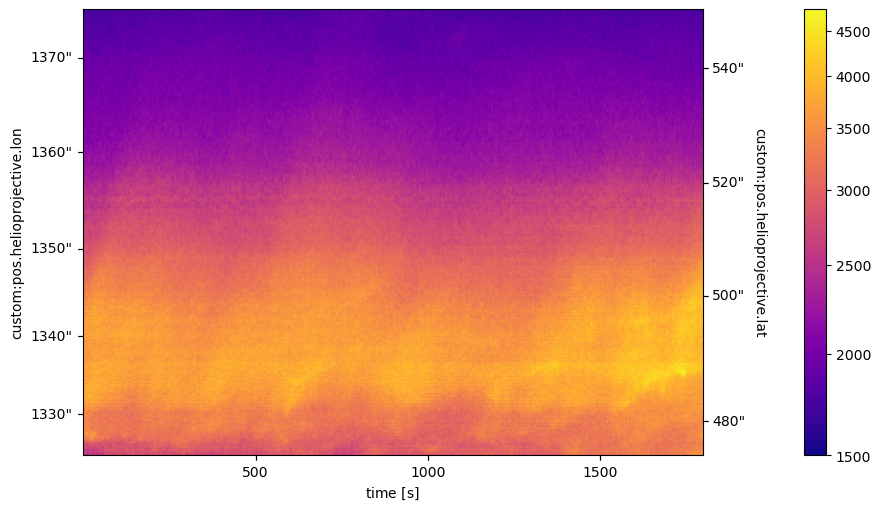

In [22]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
slit_1_spacetime_cube_new.plot(plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)))
plt.colorbar()

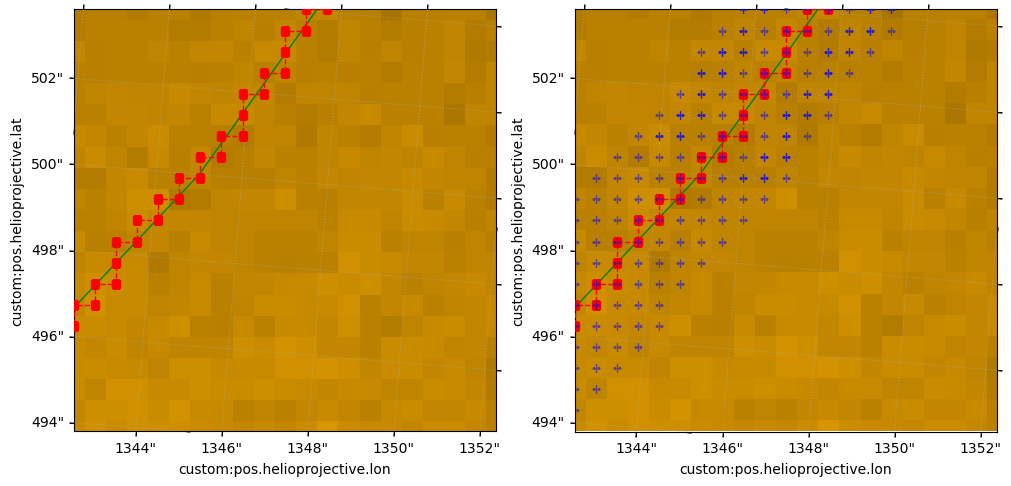

In [23]:
fig = plt.figure(figsize=(10,5),layout='constrained')

ax1 = fig.add_subplot(121,projection=eui_map_wcs_all)
ax2 = fig.add_subplot(122,projection=eui_map_wcs_all)
# eui_map_0_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))
# eui_map_0_shift.plot(axes=ax)

for ax_ in (ax1,ax2):
    ax_.imshow(eui_map_181_shift.data,origin="lower",cmap="solar orbiterhri_euv174",norm=ImageNormalize(stretch=AsinhStretch(0.1)),
            interpolation="none")

    ax_.plot_coord(slit_1_coords, color="green", lw=1, ls="-")
    # ax.plot_coord(slit_2_coords, color="red", lw=0.5, ls="-")

    ax_.set_xlim(1790,1810)
    ax_.set_ylim(645,665)

    ax_.grid("on",ls=":",alpha=0.5)

ax1.plot_coord(slit_1_pixels_0, color="red", lw=1, ls="--",marker="s")
ax2.plot_coord(slit_1_pixels_0_new, color="red", lw=1, ls="--",marker="s")
for coords in slit_1_pixels_0_new_all:
    ax2.plot_coord(coords, color="blue", lw=0,marker="+",alpha=0.5)

In [24]:
slit_1_spacetime_distance_wcs = (QuantityTableCoordinate(slit_1_pixels_0_distance.to(u.Mm),
                                                physical_types="length",names="distance") &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

In [25]:
slit_1_spacetime_distance_cube = NDCube(slit_1_intensity,slit_1_spacetime_distance_wcs)

0.1 Mm / s


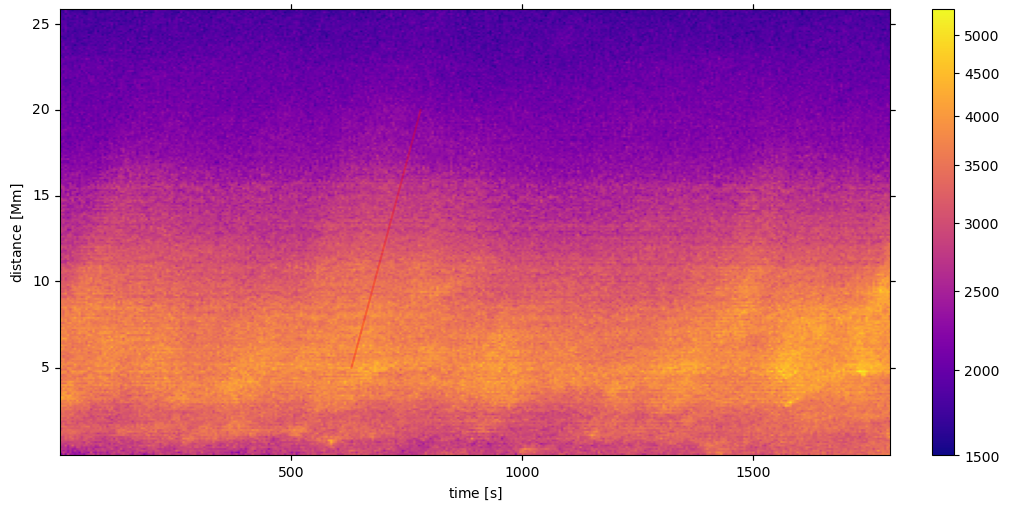

In [26]:
# this is the projected velocity 
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=slit_1_spacetime_distance_cube.wcs)
slit_1_spacetime_distance_cube.plot(axes = ax, plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)),
                                    aspect="auto")

plt.colorbar()

slit_1_spacetime_distance_slope_1_x = [630,780]*u.s
slit_1_spacetime_distance_slope_1_y = [5,20]*u.Mm
slit_1_spacetime_distance_slope_1_vel = (slit_1_spacetime_distance_slope_1_y[1] - slit_1_spacetime_distance_slope_1_y[0])/ \
    (slit_1_spacetime_distance_slope_1_x[1] - slit_1_spacetime_distance_slope_1_x[0])
slit_1_spacetime_distance_slope_1_x_pixel = slit_1_spacetime_distance_cube.wcs.world_to_pixel(slit_1_spacetime_distance_slope_1_y,slit_1_spacetime_distance_slope_1_x)
ax.plot_coord(slit_1_spacetime_distance_slope_1_x_pixel[1],slit_1_spacetime_distance_slope_1_x_pixel[0],color="red",alpha=0.3,)
print(slit_1_spacetime_distance_slope_1_vel)

# ax.set_xlim(100,200)

In [27]:
slit_1_spacetime_distance_wcs_new = (QuantityTableCoordinate(slit_1_pixels_0_distance_new.to(u.Mm),
                                                physical_types="length",names="distance") &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

slit_1_spacetime_distance_cube_new = NDCube(slit_1_intensity_new,slit_1_spacetime_distance_wcs_new)

0.1 Mm / s


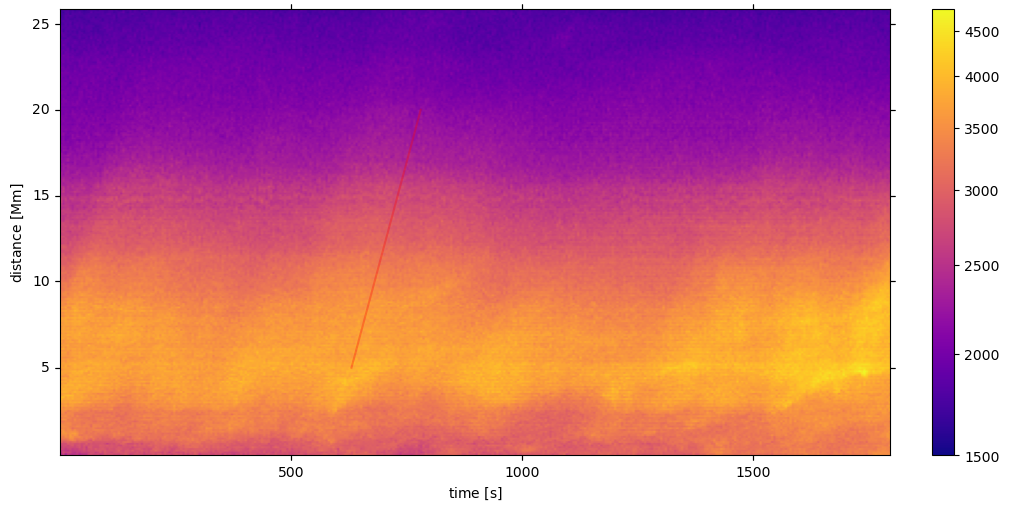

In [28]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=slit_1_spacetime_distance_cube_new.wcs)
slit_1_spacetime_distance_cube_new.plot(axes = ax, plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)),
                                    aspect="auto")
plt.colorbar()

ax.plot_coord(slit_1_spacetime_distance_slope_1_x_pixel[1],slit_1_spacetime_distance_slope_1_x_pixel[0],color="red",alpha=0.3,)
print(slit_1_spacetime_distance_slope_1_vel)


In [29]:
slit_2_pixels_0, slit_2_pixels_0_distance, slit_2_pixels_0_all,  slit_2_intensity = get_intensity_spacetime_cut_new(slit_2_coords,eui_map_seq_coalign,thick=3)

In [30]:
slit_2_spacetime_wcs = (SkyCoordTableCoordinate(slit_2_pixels_0,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs
slit_2_spacetime_cube = NDCube(slit_2_intensity,slit_2_spacetime_wcs)

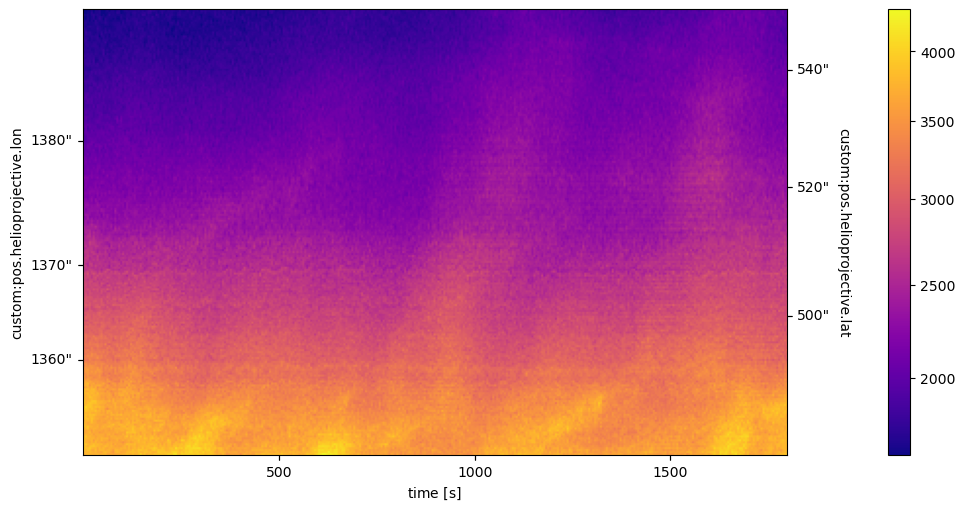

In [31]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
slit_2_spacetime_cube.plot(plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=1600,stretch=AsinhStretch(0.8)))
plt.colorbar()

In [32]:
slit_2_spacetime_distance_wcs = (QuantityTableCoordinate(slit_2_pixels_0_distance.to(u.Mm),
                                                physical_types="length",names="distance") &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs
slit_2_spacetime_distance_cube = NDCube(slit_2_intensity,slit_2_spacetime_distance_wcs)

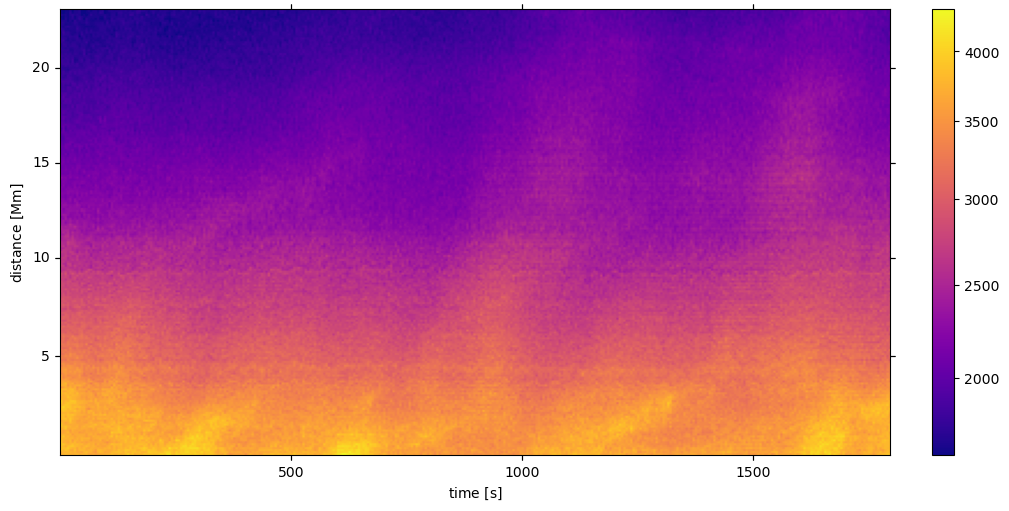

In [33]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=slit_2_spacetime_distance_cube.wcs)
slit_2_spacetime_distance_cube.plot(axes = ax, plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=1600,stretch=AsinhStretch(0.8)),
                                    aspect="auto")
plt.colorbar()

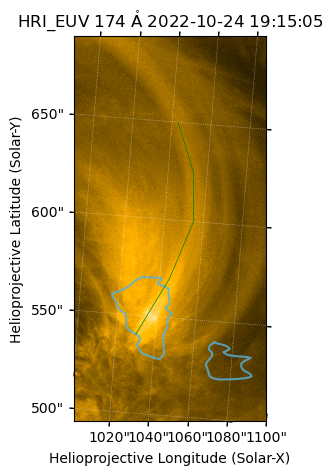

In [34]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111,projection=eui_map_wcs_all)
eui_map_181_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))
eui_map_181_shift.plot(axes=ax)

bounds = ax.axis()
eis_hhflare_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                   axes=ax)
ax.set_xlim(1100,1300)
ax.set_ylim(700,1100)

slit_3_coords = SkyCoord([1030,1045,1055,1053,1043]*u.arcsec,
                         [540,570,600,625,650]*u.arcsec,
                         frame=eui_map_181_shift.coordinate_frame)

ax.plot_coord(slit_3_coords, color="green", lw=0.5, ls="-")


In [35]:
slit_3_pixels_0,slit_3_pixels_0_distance, slit_3_pixels_0_all, slit_3_intensity = get_intensity_spacetime_cut_new(slit_3_coords,eui_map_seq_coalign)

slit_3_spacetime_wcs = (SkyCoordTableCoordinate(slit_3_pixels_0,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

In [36]:
slit_3_spacetime_cube = NDCube(slit_3_intensity,slit_3_spacetime_wcs)

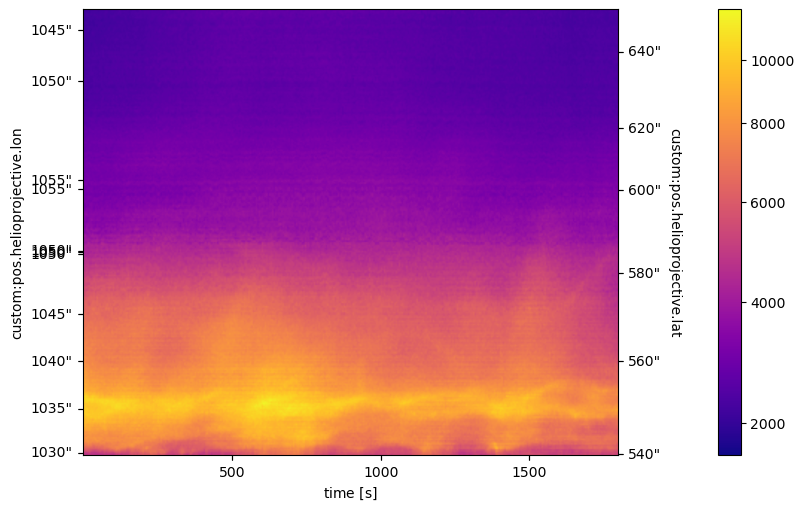

In [37]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

slit_3_spacetime_cube.plot(plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)),
                           interpolation = 'gaussian')
plt.colorbar()

In [38]:
slit_3_spacetime_distance_wcs = (QuantityTableCoordinate(slit_3_pixels_0_distance.to(u.Mm),
                                                physical_types="length",names="distance") &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs
slit_3_spacetime_distance_cube = NDCube(slit_3_intensity,slit_3_spacetime_distance_wcs)

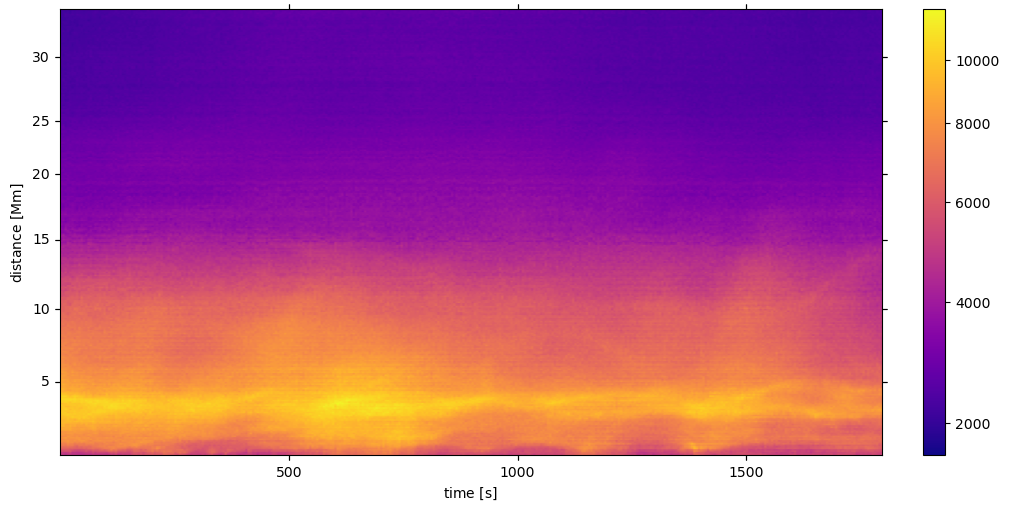

In [39]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=slit_3_spacetime_distance_cube.wcs)
slit_3_spacetime_distance_cube.plot(axes = ax, plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)),
                                    aspect="auto")

plt.colorbar()

In [40]:
eui_map_region_east = eui_map_181_shift.submap([300,300]*u.pix,top_right=[800,800]*u.pix)
eui_map_region_west = eui_map_181_shift.submap([1500,500]*u.pix,top_right=[2048,1000]*u.pix)
eui_map_region_center = eui_map_181_shift.submap([1050,700]*u.pix,top_right=[1350,1100]*u.pix)

In [41]:
def get_map_edge_coords(map):
    map_edges = sunpy.map.map_edges(map)

    x_pix = []
    y_pix = []

    for ii in range(map_edges[1].shape[0]):
        x_pix.append(map_edges[1][ii,0].value)
        y_pix.append(map_edges[1][ii,1].value)

    for ii in range(map_edges[3].shape[0]):
        x_pix.append(map_edges[3][ii,0].value)
        y_pix.append(map_edges[3][ii,1].value)

    for ii in range(map_edges[0].shape[0]-1,-1,-1):
        x_pix.append(map_edges[0][ii,0].value)
        y_pix.append(map_edges[0][ii,1].value)

    for ii in range(map_edges[2].shape[0]-1,-1,-1):
        x_pix.append(map_edges[2][ii,0].value)
        y_pix.append(map_edges[2][ii,1].value)
    
    return map.pixel_to_world(x_pix*u.pix,y_pix*u.pix)

In [42]:
def add_connection_lines(ax1,ax2,xA,yA,xB,yB,color="black"):
    con1 = patches.ConnectionPatch(xyA=(xA,yA), xyB=(xB,yB),
                      coordsA="data", coordsB="data",axesA=ax1, axesB=ax2, color="red")
    ax1.add_artist(con1)

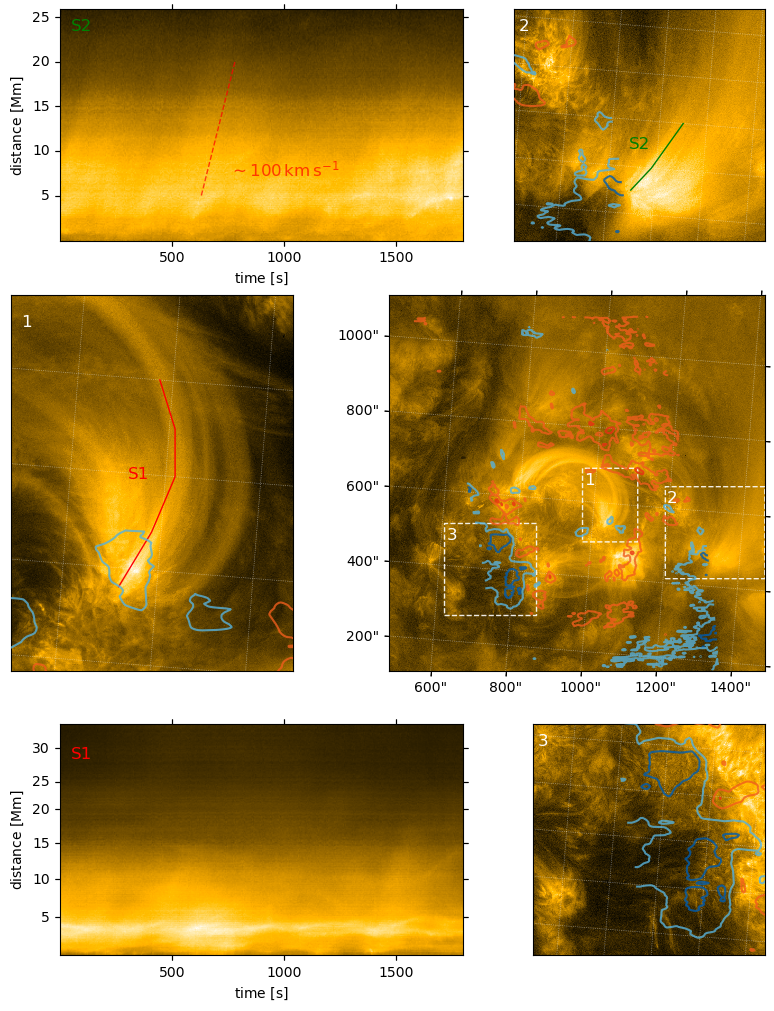

In [43]:
fig = plt.figure(figsize=(8,10),constrained_layout=True)

gs = fig.add_gridspec(nrows=4, ncols=1, left=0, right=1.0,
                      hspace=0.0, wspace=0.0,height_ratios=[2,1.5,1.5,2])

gs0 = gs[0].subgridspec(1, 20, wspace=0.0)
gs1 = gs[1:3].subgridspec(1, 20, wspace=0.0)
gs2 = gs[3].subgridspec(1, 20, wspace=0.0)

axes = {"2st":fig.add_subplot(gs0[1:12],projection=slit_1_spacetime_distance_cube.wcs),
        "2":fig.add_subplot(gs0[12:],projection=eui_map_region_west,),
        "1":fig.add_subplot(gs1[1:9],projection=eui_map_region_center,),
        "main":fig.add_subplot(gs1[9:],projection=eui_map_181_shift),
        "1st":fig.add_subplot(gs2[1:12],projection=slit_3_spacetime_distance_cube.wcs),
        "3":fig.add_subplot(gs2[12:],projection=eui_map_region_east,)}
        



eui_map_seq_coalign[181].plot(axes=axes["main"],title=None)
eui_map_region_west.plot(axes=axes["2"],title=None)
eui_map_region_center.plot(axes=axes["1"],title=None)
eui_map_region_east.plot(axes=axes["3"],title=None)

slit_1_spacetime_distance_cube_new.plot(axes = axes["2st"], plot_axes=('x','y'),
                                    cmap='solar orbiterhri_euv174',
                                    norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)),
                                    aspect="auto")

axes["2st"].plot_coord(slit_1_spacetime_distance_slope_1_x_pixel[1],slit_1_spacetime_distance_slope_1_x_pixel[0],color="red",alpha=0.7,ls="--",lw=1)
axes["2st"].text(200,80,r"$\sim 100\,{\rm km\,s^{-1}}$",fontsize=12,alpha=0.7,
                 va="center",ha="center",color="red")


slit_3_spacetime_distance_cube.plot(axes = axes["1st"], plot_axes=('x','y'),
                                    cmap='solar orbiterhri_euv174',
                                    norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)),
                                    aspect="auto")

# eui_map_region_west.draw_quadrangle(eui_map_region_west.bottom_left_coord,
#                                          top_right=eui_map_region_west.top_right_coord,
#                                          axes=axes["main"],color="white",lw=1,ls="--",alpha=0.5)
axes["main"].plot_coord(get_map_edge_coords(eui_map_region_west),color="w",lw=1,ls="--",alpha=0.9)
axes["main"].plot_coord(get_map_edge_coords(eui_map_region_east),color="w",lw=1,ls="--",alpha=0.9)
axes["main"].plot_coord(get_map_edge_coords(eui_map_region_center),color="w",lw=1,ls="--",alpha=0.9)

axes["main"].text(1060,1080,"1",color="white",fontsize=12,ha="left",va="top")
axes["main"].text(310,780,"3",color="white",fontsize=12,ha="left",va="top")
axes["main"].text(1510,980,"2",color="white",fontsize=12,ha="left",va="top")

axes["2"].text(10,480,"2",color="white",fontsize=12,ha="left",va="top")
axes["2"].text(270,210,"S2",color="green",fontsize=12,ha="center",va="center")
axes["2st"].text(10,248,"S2",color="green",fontsize=12,ha="left",va="top")

axes["3"].text(10,480,"3",color="white",fontsize=12,ha="left",va="top")

axes["1"].text(10,380,"1",color="white",fontsize=12,ha="left",va="top")
axes["1"].text(135,210,"S1",color="red",fontsize=12,ha="center",va="center")
axes["1st"].text(10,270,"S1",color="red",fontsize=12,ha="left",va="top")


axes["2"].plot_coord(slit_1_coords, color="green", lw=1, ls="-")
axes["1"].plot_coord(slit_3_coords, color="red", lw=1, ls="-")

for ax_str in ("1","2","3","main"):
    axes[ax_str].set_anchor('E')
    axes[ax_str].set_ylabel(" ")
    axes[ax_str].set_xlabel(" ")


for ax_str in ("2","3","main"):
    bounds = axes[ax_str].axis()
    eis_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,axes=axes[ax_str])
    axes[ax_str].axis(bounds)

bounds = axes["1"].axis()
eis_hhflare_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,axes=axes["1"])
axes["1"].axis(bounds)

for ax_str in ("2st","1st"):
    axes[ax_str].set_anchor('W')

for ax_str in ("1","2","3"):
    axes[ax_str].tick_params(axis="x",bottom=False, top=False, left=False, right=False,
                             labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    axes[ax_str].tick_params(axis="y",bottom=False, top=False, left=False, right=False,
                             labelbottom=False, labeltop=False, labelleft=False, labelright=False)

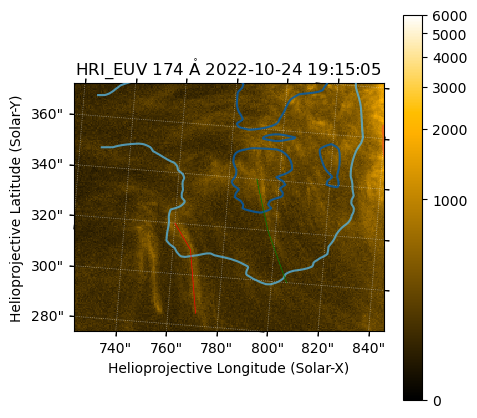

In [44]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111,projection=eui_map_wcs_all)
eui_map_181_shift.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=6e3,stretch=AsinhStretch(0.05))
eui_map_181_shift.plot(axes=ax)
plt.colorbar()

bounds = ax.axis()
eis_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                   axes=ax)
ax.set_xlim(500,750)
ax.set_ylim(300,500)

slit_4_coords = SkyCoord([791,797,806]*u.arcsec,
                         [340,320,300]*u.arcsec,
                         frame=eui_map_181_shift.coordinate_frame)

slit_5_coords = SkyCoord([760,767,771]*u.arcsec,
                            [320,310,285]*u.arcsec,
                            frame=eui_map_181_shift.coordinate_frame)

ax.plot_coord(slit_4_coords, color="green", lw=0.5, ls="-")
ax.plot_coord(slit_5_coords, color="red", lw=0.5, ls="-")

In [45]:
slit_4_pixels_0, slit_4_pixels_0_distance, slit_4_pixels_0_all, slit_4_intensity = get_intensity_spacetime_cut_new(slit_4_coords,eui_map_seq_coalign)

slit_4_spacetime_wcs = (SkyCoordTableCoordinate(slit_4_pixels_0,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

In [46]:
slit_4_spacetime_cube = NDCube(slit_4_intensity,slit_4_spacetime_wcs)

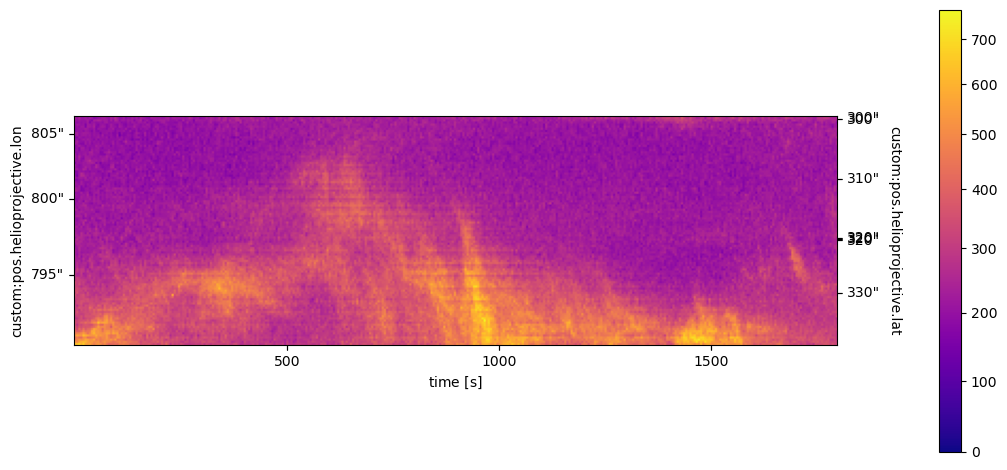

In [47]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

slit_4_spacetime_cube.plot(plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.7)))
plt.colorbar()

In [48]:
slit_4_spacetime_distance_wcs = (QuantityTableCoordinate(slit_4_pixels_0_distance.to(u.Mm),
                                                physical_types="length",names="distance") &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs
slit_4_spacetime_distance_cube = NDCube(slit_4_intensity,slit_4_spacetime_distance_wcs)

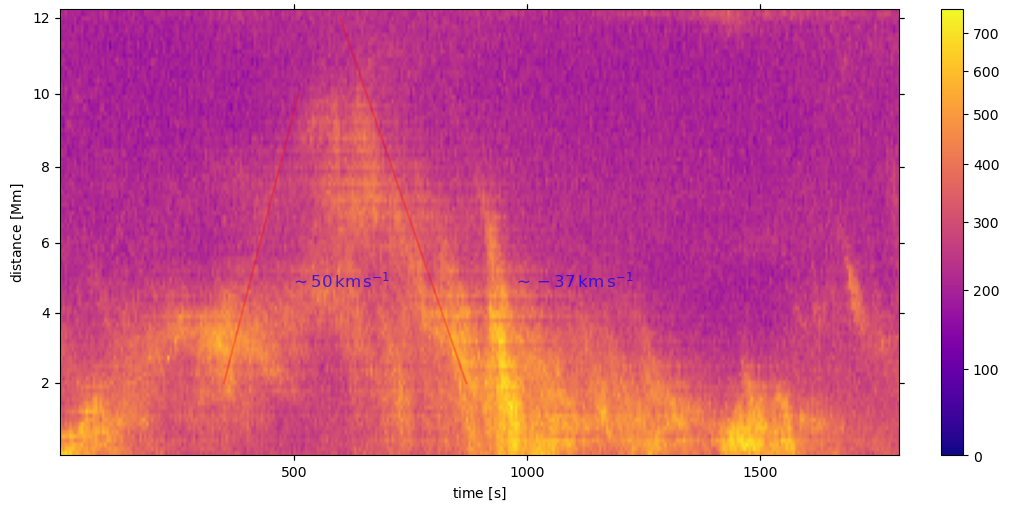

In [49]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=slit_4_spacetime_distance_cube.wcs)
slit_4_spacetime_distance_cube.plot(axes = ax, plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.4)),
                                    aspect="auto")

slit_4_spacetime_distance_slope_1_x = [350,510]*u.s
slit_4_spacetime_distance_slope_1_y = [2,10]*u.Mm
slit_4_spacetime_distance_slope_1_vel = (slit_4_spacetime_distance_slope_1_y[1] - slit_4_spacetime_distance_slope_1_y[0])/ \
    (slit_4_spacetime_distance_slope_1_x[1] - slit_4_spacetime_distance_slope_1_x[0])
slit_4_spacetime_distance_slope_1_x_pixel = slit_4_spacetime_distance_cube.wcs.world_to_pixel(slit_4_spacetime_distance_slope_1_y,slit_4_spacetime_distance_slope_1_x)
ax.plot_coord(slit_4_spacetime_distance_slope_1_x_pixel[1],slit_4_spacetime_distance_slope_1_x_pixel[0],color="red",alpha=0.3,)
ax.text(5,600,r"$\sim {:.0f}\,{{\rm km\,s^{{-1}}}}$".format(slit_4_spacetime_distance_slope_1_vel.to_value(u.km/u.s)),fontsize=12,alpha=0.7,
        transform=ax.get_transform("world"),va="center",ha="center",color="b")

slit_4_spacetime_distance_slope_2_x = [600,870]*u.s
slit_4_spacetime_distance_slope_2_y = [12,2]*u.Mm
slit_4_spacetime_distance_slope_2_vel = (slit_4_spacetime_distance_slope_2_y[1] - slit_4_spacetime_distance_slope_2_y[0])/ \
    (slit_4_spacetime_distance_slope_2_x[1] - slit_4_spacetime_distance_slope_2_x[0])
slit_4_spacetime_distance_slope_2_x_pixel = slit_4_spacetime_distance_cube.wcs.world_to_pixel(slit_4_spacetime_distance_slope_2_y,slit_4_spacetime_distance_slope_2_x)
ax.plot_coord(slit_4_spacetime_distance_slope_2_x_pixel[1],slit_4_spacetime_distance_slope_2_x_pixel[0],color="red",alpha=0.3,)
ax.text(5,1100,r"$\sim {:.0f}\,{{\rm km\,s^{{-1}}}}$".format(slit_4_spacetime_distance_slope_2_vel.to_value(u.km/u.s)),fontsize=12,alpha=0.7,
        transform=ax.get_transform("world"),va="center",ha="center",color="b")



plt.colorbar()

In [50]:
slit_5_pixels_0, slit_5_pixels_0_distance, slit_5_pixels_0_all, slit_5_intensity = get_intensity_spacetime_cut_new(slit_5_coords,eui_map_seq_coalign)

slit_5_spacetime_wcs = (SkyCoordTableCoordinate(slit_5_pixels_0,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

slit_5_spacetime_cube = NDCube(slit_5_intensity,slit_5_spacetime_wcs)

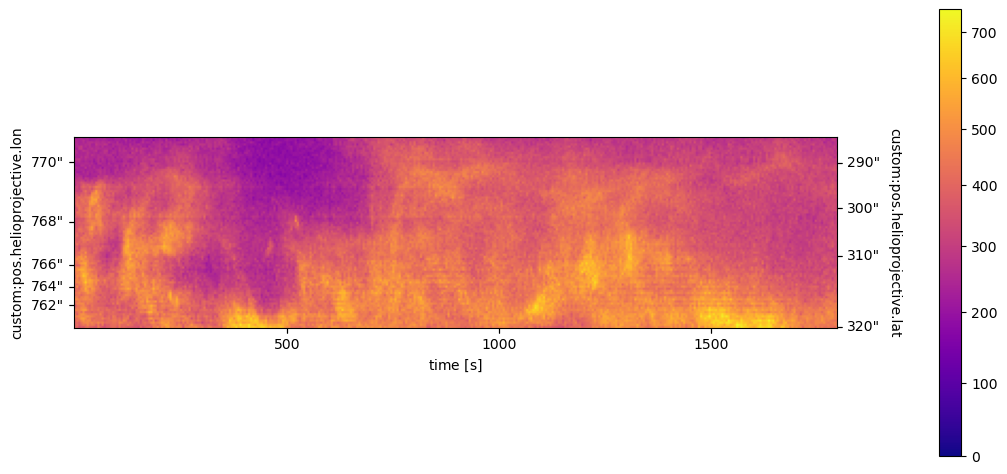

In [51]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

slit_5_spacetime_cube.plot(plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.7)))
plt.colorbar()

In [52]:
slit_5_spacetime_distance_wcs = (QuantityTableCoordinate(slit_5_pixels_0_distance.to(u.Mm),
                                                physical_types="length",names="distance") &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs
slit_5_spacetime_distance_cube = NDCube(slit_5_intensity,slit_5_spacetime_distance_wcs)

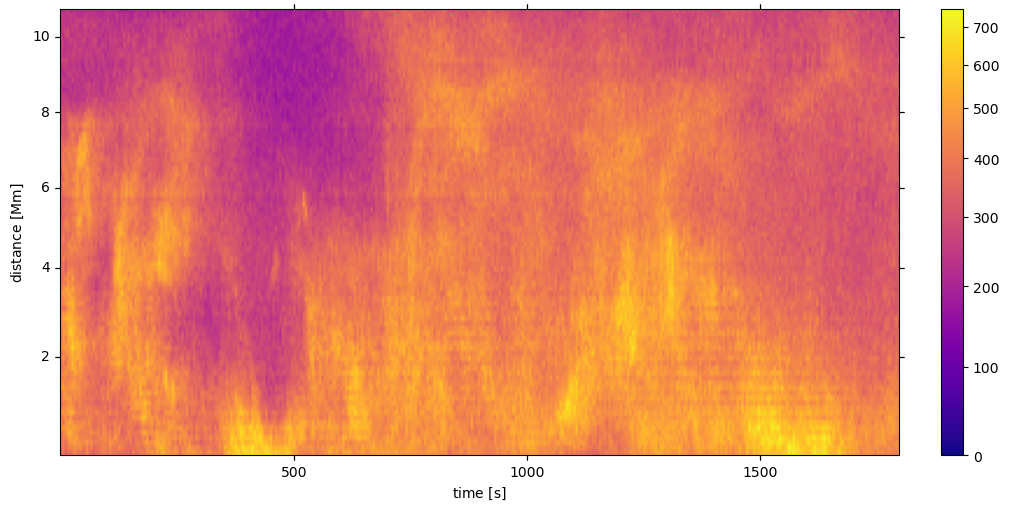

In [53]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=slit_5_spacetime_distance_cube.wcs)
slit_5_spacetime_distance_cube.plot(axes = ax, plot_axes=('x','y'),cmap='plasma',norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.4)),
                                    aspect="auto")
plt.colorbar()